In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# 1) Carregar e preparar a série temporal mensal
df10 = pd.read_csv('/IMP_2010.csv', sep=';')
df11 = pd.read_csv('/IMP_2011.csv', sep=';')
df12 = pd.read_csv('/IMP_2012.csv', sep=';')
df13 = pd.read_csv('/IMP_2013.csv', sep=';')
df14 = pd.read_csv('/IMP_2014.csv', sep=';')
df15 = pd.read_csv('/IMP_2015.csv', sep=';')
df16 = pd.read_csv('/IMP_2016.csv', sep=';')
df17 = pd.read_csv('/IMP_2017.csv', sep=';')
df18 = pd.read_csv('/IMP_2018.csv', sep=';')
df19 = pd.read_csv('/IMP_2019.csv', sep=';')
df20 = pd.read_csv('/IMP_2020.csv', sep=';')
df21 = pd.read_csv('/IMP_2021.csv', sep=';')
df22 = pd.read_csv('/IMP_2022.csv', sep=';')
df23 = pd.read_csv('/IMP_2023.csv', sep=';')
df24 = pd.read_csv('/IMP_2024.csv', sep=';')
df = pd.concat([df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23, df24], ignore_index=True)


In [ ]:
#31052000
#84713012
df_main = df[(df['CO_NCM'] == 84713012)].copy()
df_main['CO_ANO'] = df['CO_ANO'].astype(int)
df_main['CO_MES'] = df['CO_MES'].astype(int)
df_main['date'] = pd.to_datetime(df_main['CO_ANO'].astype(str) + '-' + df_main['CO_MES'].astype(str) + '-01')
ts = df_main.groupby('date')['KG_LIQUIDO'].sum().sort_index()

In [ ]:
ts


,KG_LIQUIDO
date,
2010-01-01,49677
2010-02-01,46104
2010-03-01,96411
2010-04-01,125201
2010-05-01,116023
...,...
2024-08-01,29665
2024-09-01,19501
2024-10-01,25416


In [ ]:
# 2) Normalizar (MinMax)
values = ts.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# 3) Gerar janelas (window = 12 meses)
window = 12
X, y = [], []
for i in range(window, len(scaled)):
    X.append(scaled[i-window:i, 0])
    y.append(scaled[i, 0])
X, y = np.array(X), np.array(y)

# 4) Reshape para [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# 5) Separar treino e teste (80% treino)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]





In [ ]:
# --- 1. Definir a métrica R² ---
import tensorflow.keras.backend as K
def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 - 6s - 938ms/step - loss: 0.4588 - mae: 0.4043 - mape: 4787463.5000 - mse: 0.2135 - rmse: 0.4620 - val_loss: 0.1556 - val_mae: 0.1493 - val_mape: 226.6840 - val_mse: 0.0243 - val_rmse: 0.1560
Epoch 2/100


6/6 - 0s - 55ms/step - loss: 0.2842 - mae: 0.2322 - mape: 2412278.5000 - mse: 0.0821 - rmse: 0.2864 - val_loss: 0.1018 - val_mae: 0.0913 - val_mape: 94.5277 - val_mse: 0.0104 - val_rmse: 0.1019
Epoch 3/100


6/6 - 1s - 102ms/step - loss: 0.3070 - mae: 0.2445 - mape: 1645545.0000 - mse: 0.0964 - rmse: 0.3104 - val_loss: 0.0816 - val_mae: 0.0681 - val_mape: 63.9651 - val_mse: 0.0067 - val_rmse: 0.0816
Epoch 4/100


6/6 - 1s - 104ms/step - loss: 0.2752 - mae: 0.2198 - mape: 1692934.2500 - mse: 0.0789 - rmse: 0.2809 - val_loss: 0.0505 - val_mae: 0.0443 - val_mape: 73.3742 - val_mse: 0.0028 - val_rmse: 0.0530
Epoch 5/100
6/6 - 1s - 102ms/step - loss: 0.2786 - mae: 0.2222 - mape: 693994.0000 - mse: 0.0793 - rmse: 0.2816 - val_loss: 0.0750 - val_mae: 0.0685 - val_mape: 112.8682 - val_mse: 0.0058 - val_rmse: 0.0763
Epoch 6/100


6/6 - 1s - 109ms/step - loss: 0.2476 - mae: 0.1996 - mape: 2607884.0000 - mse: 0.0618 - rmse: 0.2487 - val_loss: 0.0500 - val_mae: 0.0437 - val_mape: 72.4305 - val_mse: 0.0028 - val_rmse: 0.0525
Epoch 7/100
6/6 - 0s - 55ms/step - loss: 0.2937 - mae: 0.2345 - mape: 810818.4375 - mse: 0.0869 - rmse: 0.2948 - val_loss: 0.0549 - val_mae: 0.0410 - val_mape: 39.5798 - val_mse: 0.0030 - val_rmse: 0.0550
Epoch 8/100


6/6 - 0s - 37ms/step - loss: 0.2539 - mae: 0.2032 - mape: 1109475.2500 - mse: 0.0646 - rmse: 0.2542 - val_loss: 0.0441 - val_mae: 0.0377 - val_mape: 59.3256 - val_mse: 0.0022 - val_rmse: 0.0467
Epoch 9/100
6/6 - 0s - 29ms/step - loss: 0.2378 - mae: 0.1938 - mape: 1686591.2500 - mse: 0.0579 - rmse: 0.2406 - val_loss: 0.0727 - val_mae: 0.0663 - val_mape: 109.4688 - val_mse: 0.0055 - val_rmse: 0.0740
Epoch 10/100
6/6 - 0s - 30ms/step - loss: 0.2497 - mae: 0.2035 - mape: 501462.6250 - mse: 0.0656 - rmse: 0.2562 - val_loss: 0.0745 - val_mae: 0.0680 - val_mape: 112.0489 - val_mse: 0.0057 - val_rmse: 0.0757
Epoch 11/100


6/6 - 0s - 60ms/step - loss: 0.2579 - mae: 0.2051 - mape: 2512495.0000 - mse: 0.0679 - rmse: 0.2606 - val_loss: 0.0429 - val_mae: 0.0363 - val_mape: 50.7073 - val_mse: 0.0020 - val_rmse: 0.0446
Epoch 12/100
6/6 - 0s - 38ms/step - loss: 0.2281 - mae: 0.1754 - mape: 159448.7188 - mse: 0.0534 - rmse: 0.2310 - val_loss: 0.0493 - val_mae: 0.0430 - val_mape: 71.2635 - val_mse: 0.0027 - val_rmse: 0.0518
Epoch 13/100
6/6 - 0s - 32ms/step - loss: 0.2219 - mae: 0.1780 - mape: 903966.8125 - mse: 0.0506 - rmse: 0.2250 - val_loss: 0.0602 - val_mae: 0.0541 - val_mape: 90.1099 - val_mse: 0.0038 - val_rmse: 0.0620
Epoch 14/100
6/6 - 0s - 47ms/step - loss: 0.2482 - mae: 0.1925 - mape: 1628727.0000 - mse: 0.0622 - rmse: 0.2495 - val_loss: 0.0492 - val_mae: 0.0429 - val_mape: 71.1013 - val_mse: 0.0027 - val_rmse: 0.0517
Epoch 15/100
6/6 - 0s - 29ms/step - loss: 0.2284 - mae: 0.1825 - mape: 769243.8750 - mse: 0.0523 - rmse: 0.2288 - val_loss: 0.0449 - val_mae: 0.0383 - val_mape: 61.6784 - val_mse: 0.0023 

6/6 - 0s - 37ms/step - loss: 0.2316 - mae: 0.1890 - mape: 1713191.5000 - mse: 0.0541 - rmse: 0.2325 - val_loss: 0.0426 - val_mae: 0.0361 - val_mape: 50.9688 - val_mse: 0.0020 - val_rmse: 0.0444
Epoch 17/100


6/6 - 0s - 39ms/step - loss: 0.2065 - mae: 0.1621 - mape: 1328642.6250 - mse: 0.0442 - rmse: 0.2101 - val_loss: 0.0426 - val_mae: 0.0361 - val_mape: 53.7553 - val_mse: 0.0020 - val_rmse: 0.0448
Epoch 18/100
6/6 - 0s - 30ms/step - loss: 0.2323 - mae: 0.1879 - mape: 4896077.0000 - mse: 0.0551 - rmse: 0.2348 - val_loss: 0.0429 - val_mae: 0.0365 - val_mape: 55.9469 - val_mse: 0.0021 - val_rmse: 0.0453
Epoch 19/100
6/6 - 0s - 30ms/step - loss: 0.2235 - mae: 0.1765 - mape: 744136.8125 - mse: 0.0504 - rmse: 0.2244 - val_loss: 0.0503 - val_mae: 0.0440 - val_mape: 73.2363 - val_mse: 0.0028 - val_rmse: 0.0527
Epoch 20/100
6/6 - 0s - 52ms/step - loss: 0.2318 - mae: 0.1795 - mape: 2010074.7500 - mse: 0.0542 - rmse: 0.2327 - val_loss: 0.0724 - val_mae: 0.0660 - val_mape: 109.0268 - val_mse: 0.0054 - val_rmse: 0.0737
Epoch 21/100
6/6 - 0s - 46ms/step - loss: 0.2269 - mae: 0.1845 - mape: 415768.9688 - mse: 0.0522 - rmse: 0.2285 - val_loss: 0.0673 - val_mae: 0.0612 - val_mape: 101.3667 - val_mse: 0.00

6/6 - 0s - 62ms/step - loss: 0.1853 - mae: 0.1449 - mape: 180951.8750 - mse: 0.0358 - rmse: 0.1891 - val_loss: 0.0423 - val_mae: 0.0357 - val_mape: 54.4335 - val_mse: 0.0020 - val_rmse: 0.0446
Epoch 34/100
6/6 - 0s - 29ms/step - loss: 0.1763 - mae: 0.1399 - mape: 857836.3125 - mse: 0.0314 - rmse: 0.1772 - val_loss: 0.0426 - val_mae: 0.0355 - val_mape: 47.8059 - val_mse: 0.0019 - val_rmse: 0.0439
Epoch 35/100
6/6 - 0s - 30ms/step - loss: 0.1673 - mae: 0.1306 - mape: 1031345.8125 - mse: 0.0287 - rmse: 0.1694 - val_loss: 0.0509 - val_mae: 0.0445 - val_mape: 74.4218 - val_mse: 0.0028 - val_rmse: 0.0532
Epoch 36/100
6/6 - 0s - 31ms/step - loss: 0.1647 - mae: 0.1295 - mape: 1479381.2500 - mse: 0.0276 - rmse: 0.1660 - val_loss: 0.0446 - val_mae: 0.0380 - val_mape: 61.6823 - val_mse: 0.0022 - val_rmse: 0.0472
Epoch 37/100
6/6 - 0s - 48ms/step - loss: 0.1560 - mae: 0.1249 - mape: 1401846.2500 - mse: 0.0250 - rmse: 0.1580 - val_loss: 0.0473 - val_mae: 0.0364 - val_mape: 40.4991 - val_mse: 0.0023

6/6 - 0s - 59ms/step - loss: 0.1603 - mae: 0.1233 - mape: 2118169.0000 - mse: 0.0260 - rmse: 0.1612 - val_loss: 0.0422 - val_mae: 0.0355 - val_mape: 48.9009 - val_mse: 0.0019 - val_rmse: 0.0437
Epoch 42/100


6/6 - 0s - 43ms/step - loss: 0.1553 - mae: 0.1141 - mape: 394265.8750 - mse: 0.0243 - rmse: 0.1559 - val_loss: 0.0420 - val_mae: 0.0354 - val_mape: 49.8864 - val_mse: 0.0019 - val_rmse: 0.0437
Epoch 43/100
6/6 - 0s - 45ms/step - loss: 0.1477 - mae: 0.1162 - mape: 285168.4062 - mse: 0.0223 - rmse: 0.1493 - val_loss: 0.0537 - val_mae: 0.0474 - val_mape: 79.3432 - val_mse: 0.0031 - val_rmse: 0.0557
Epoch 44/100


6/6 - 0s - 40ms/step - loss: 0.1560 - mae: 0.1206 - mape: 1600458.6250 - mse: 0.0249 - rmse: 0.1576 - val_loss: 0.0420 - val_mae: 0.0354 - val_mape: 53.1432 - val_mse: 0.0019 - val_rmse: 0.0441
Epoch 45/100
6/6 - 0s - 35ms/step - loss: 0.1648 - mae: 0.1284 - mape: 403439.9375 - mse: 0.0277 - rmse: 0.1666 - val_loss: 0.0438 - val_mae: 0.0370 - val_mape: 59.5645 - val_mse: 0.0021 - val_rmse: 0.0463
Epoch 46/100
6/6 - 0s - 31ms/step - loss: 0.1554 - mae: 0.1235 - mape: 158895.0000 - mse: 0.0250 - rmse: 0.1581 - val_loss: 0.0569 - val_mae: 0.0506 - val_mape: 84.7256 - val_mse: 0.0034 - val_rmse: 0.0587
Epoch 47/100
6/6 - 0s - 36ms/step - loss: 0.1534 - mae: 0.1236 - mape: 269484.7812 - mse: 0.0243 - rmse: 0.1558 - val_loss: 0.0435 - val_mae: 0.0368 - val_mape: 58.9701 - val_mse: 0.0021 - val_rmse: 0.0460
Epoch 48/100
6/6 - 0s - 50ms/step - loss: 0.1526 - mae: 0.1205 - mape: 589136.1250 - mse: 0.0238 - rmse: 0.1544 - val_loss: 0.0429 - val_mae: 0.0362 - val_mape: 57.1327 - val_mse: 0.0021 -

6/6 - 1s - 109ms/step - loss: 0.1463 - mae: 0.1148 - mape: 798535.7500 - mse: 0.0219 - rmse: 0.1481 - val_loss: 0.0420 - val_mae: 0.0353 - val_mape: 49.1314 - val_mse: 0.0019 - val_rmse: 0.0435
Epoch 54/100
6/6 - 0s - 51ms/step - loss: 0.1356 - mae: 0.1045 - mape: 515973.9062 - mse: 0.0201 - rmse: 0.1418 - val_loss: 0.0455 - val_mae: 0.0390 - val_mape: 63.8300 - val_mse: 0.0023 - val_rmse: 0.0480
Epoch 55/100
6/6 - 0s - 56ms/step - loss: 0.1419 - mae: 0.1098 - mape: 236833.2969 - mse: 0.0204 - rmse: 0.1429 - val_loss: 0.0524 - val_mae: 0.0460 - val_mape: 77.0549 - val_mse: 0.0030 - val_rmse: 0.0545
Epoch 56/100


6/6 - 0s - 60ms/step - loss: 0.1348 - mae: 0.1068 - mape: 247382.6719 - mse: 0.0184 - rmse: 0.1356 - val_loss: 0.0418 - val_mae: 0.0353 - val_mape: 51.6824 - val_mse: 0.0019 - val_rmse: 0.0437
Epoch 57/100
6/6 - 1s - 101ms/step - loss: 0.1466 - mae: 0.1132 - mape: 1060372.2500 - mse: 0.0218 - rmse: 0.1476 - val_loss: 0.0419 - val_mae: 0.0353 - val_mape: 50.0043 - val_mse: 0.0019 - val_rmse: 0.0435
Epoch 58/100
6/6 - 0s - 52ms/step - loss: 0.1406 - mae: 0.1047 - mape: 514152.1875 - mse: 0.0211 - rmse: 0.1451 - val_loss: 0.0571 - val_mae: 0.0509 - val_mape: 85.1320 - val_mse: 0.0035 - val_rmse: 0.0589
Epoch 59/100
6/6 - 0s - 83ms/step - loss: 0.1372 - mae: 0.1048 - mape: 1129711.0000 - mse: 0.0198 - rmse: 0.1409 - val_loss: 0.0495 - val_mae: 0.0431 - val_mape: 71.9140 - val_mse: 0.0027 - val_rmse: 0.0518
Epoch 60/100
6/6 - 0s - 49ms/step - loss: 0.1352 - mae: 0.1050 - mape: 1134553.3750 - mse: 0.0187 - rmse: 0.1366 - val_loss: 0.0429 - val_mae: 0.0362 - val_mape: 57.1286 - val_mse: 0.002

6/6 - 0s - 36ms/step - loss: 0.1328 - mae: 0.1003 - mape: 1507524.0000 - mse: 0.0188 - rmse: 0.1372 - val_loss: 0.0418 - val_mae: 0.0353 - val_mape: 50.3416 - val_mse: 0.0019 - val_rmse: 0.0435
Epoch 68/100
6/6 - 0s - 47ms/step - loss: 0.1512 - mae: 0.1116 - mape: 1417016.0000 - mse: 0.0232 - rmse: 0.1524 - val_loss: 0.0630 - val_mae: 0.0570 - val_mape: 94.7858 - val_mse: 0.0042 - val_rmse: 0.0646
Epoch 69/100
6/6 - 0s - 29ms/step - loss: 0.1384 - mae: 0.1089 - mape: 887772.1875 - mse: 0.0193 - rmse: 0.1390 - val_loss: 0.0481 - val_mae: 0.0416 - val_mape: 69.1929 - val_mse: 0.0025 - val_rmse: 0.0505
Epoch 70/100
6/6 - 0s - 51ms/step - loss: 0.1294 - mae: 0.0956 - mape: 390325.4688 - mse: 0.0172 - rmse: 0.1311 - val_loss: 0.0438 - val_mae: 0.0353 - val_mape: 44.0035 - val_mse: 0.0020 - val_rmse: 0.0446
Epoch 71/100
6/6 - 0s - 47ms/step - loss: 0.1286 - mae: 0.0977 - mape: 1591201.5000 - mse: 0.0175 - rmse: 0.1323 - val_loss: 0.0428 - val_mae: 0.0361 - val_mape: 57.0731 - val_mse: 0.0020

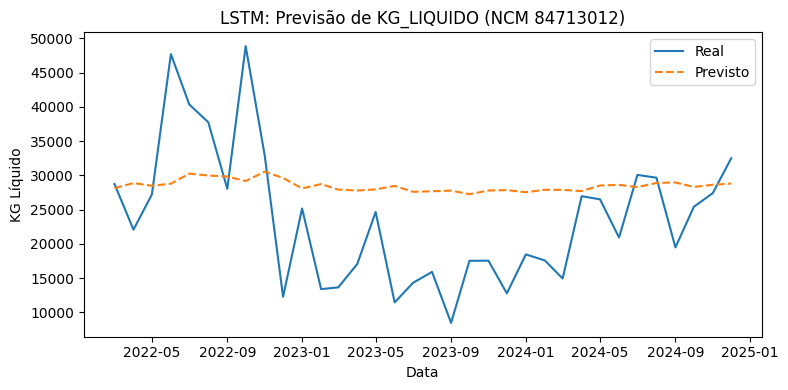

In [ ]:
# 6) Definir o modelo LSTM
model = Sequential([
    LSTM(50, activation='sigmoid', input_shape=(window, 1),
         dropout=0.20,            # 20% de dropout nas entradas
         recurrent_dropout=0.20   # 20% de dropout nos estados recorrentes
         ),
    Dropout(0.20),
    Dense(10),
    Dense(1)
])

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
rmse_metric = tf.keras.metrics.RootMeanSquaredError(name="rmse")
import tensorflow.keras.backend as K

def rmse_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

#mse
model.compile(optimizer=opt, loss=rmse_loss, metrics=['mape', 'mae',
                                                  'mse', rmse_metric])

#model.load_weights('/content/melhor_modelo_MAPE.h5')

checkpoint_cb = ModelCheckpoint(
    'melhor_modelo_.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

es_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

#model.load_weights('/content/melhor_modelo_2.h5')



## 7) Treinar
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=25,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_cb],
    verbose=2
)

# 8) Previsão e inversão de escala
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 9) Plotar resultados
plt.figure(figsize=(8, 4))
plt.plot(ts.index[window + split:], y_test_inv, label='Real')
plt.plot(ts.index[window + split:], y_pred_inv, label='Previsto', linestyle='--')
plt.title('LSTM: Previsão de KG_LIQUIDO (NCM 84713012)')
plt.xlabel('Data')
plt.ylabel('KG Líquido')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# supondo que você salvou com:
# model.save('melhor_modelo.h5')
# ou o ModelCheckpoint criou esse arquivo

model.load_weights('/content/melhor_modelo_.h5')
scoreCkpt = model.evaluate(X_test, y_test, verbose=2)

2/2 - 0s - 26ms/step - loss: 0.0433 - mae: 0.0353 - mape: 50.3416 - mse: 0.0019 - rmse: 0.0435


In [ ]:
print(scoreCkpt)

[0.03826436772942543, 38.34309387207031, 0.029195383191108704, 0.0014686931390315294, 0.0383235327899456]
